# Name Analysis and forecasting

Exploration of the United States Social Security Administration babynames dataset made available via R package [babynames](http://hadley.github.io/babynames/).

* Visualizing baby names over time
* Using [Prophet](https://facebook.github.io/prophet/) to forecast if popularity will continue to rise or fall
* Using ARIMA from [StatsModels](https://www.statsmodels.org/) to forecast if popularity will continue to rise or fall
* Evaluation of name popularity using 'phonetic' algorithms
* Probability of child having another child in their same class with a simlar name

As the babynames package is in R, and I generally prefer Python, I've used the [rpy2](https://rpy2.bitbucket.io) library to pull in the appropriate portions of babynames

## Setup

All required packages should be in the first code cell. If you use conda, you likely have most requirements already met. Some specific steps I had to follow from my existing conda environment:

```
# do this if you only want rpy2 and already have R installed.
pip install rpy2
# otherwise run
# conda install rpy2
conda install tzlocal line_profiler
conda install -c conda-forge fbprophet
conda install -c conda-forge abydos
```

For R, make sure you have the package babynames installed by running `install.packages('babynames')` in an R session

## Table of Contents:
* [Load Baby Names Data](#load_data)
* [Prediction with Prophet](#prophet)
* [Prediction with ARIMA](#arima)
* [Combine names based on pronounciation](#sound_analysis)
* [Name popularity](#popularity)
* [Gender overlap in naming](#gender)

## To Do:

* Get someone smart to review this work!

In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# enable automatic conversion between R dataframes and Pandas Dataframes
pandas2ri.activate()

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import os
import pickle
import itertools

from timeit import default_timer as timer

import multiprocessing
from multiprocessing import Pool
import psutil
from functools import partial

# to prevent some warnings later on
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
%load_ext line_profiler

In [3]:
import seaborn as sns
sns.set()
sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.9',
    'grid.linestyle': u'-',
    'figure.facecolor': 'white', # axes
})
sns.set_context("notebook")

<a id='load_data'></a>

## Loading the name data

Summary of data available in the R package [babynames](http://hadley.github.io/babynames/):

**babynames:** For each year from 1880 to 2017, the number of children of each sex given each name. All names with more than 5 uses are given. (Source: http://www.ssa.gov/oact/babynames/limits.html)

**applicants:** The number of applicants for social security numbers (SSN) for each year for each sex. (Source: http://www.ssa.gov/oact/babynames/numberUSbirths.html)

**lifetables:** Cohort life tables data (Source: http://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html)

It also includes the following data set from the US Census:

**births:** Number of live births by year, up to 2017. (Source: an Excel spreadsheet from the Census that has since been removed from their website and https://www.cdc.gov/nchs/data/nvsr/nvsr66/nvsr66_01.pdf)

In [4]:
bn_filename = 'babynames.pickle'

if os.path.isfile(bn_filename):
    with open(bn_filename, 'rb') as f:
        orig_df = pickle.load(f)
else:
    bn = importr('babynames')
    orig_df = bn.__rdata__.fetch('babynames')['babynames']
    # fix some data types
    orig_df['year'] = orig_df.year.astype('int32')

    with open(bn_filename, 'wb') as f:
        pickle.dump(orig_df, f)

In [5]:
# only want to look at more recent trends
df = orig_df[orig_df.year >= 1990].copy()

In [6]:
df.head()

,year,sex,name,n,prop
1069606,1990,F,Jessica,46475,0.022627
1069607,1990,F,Ashley,45558,0.022181
1069608,1990,F,Brittany,36538,0.017789
1069609,1990,F,Amanda,34408,0.016752
1069610,1990,F,Samantha,25866,0.012593


In [7]:
df.tail()

,year,sex,name,n,prop
1924661,2017,M,Zykai,5,0.000003
1924662,2017,M,Zykeem,5,0.000003
1924663,2017,M,Zylin,5,0.000003
1924664,2017,M,Zylis,5,0.000003
1924665,2017,M,Zyrie,5,0.000003


In [8]:
tops = df[(df.sex == 'F') & ((df.year >= 2012) & (df.year <= 2017))].sort_values(['year', 'n'], ascending=False).groupby('year', as_index=False).head(20)
print('top femail names 2012 - 2017 by number of times in top 20 per year')
print(tops.groupby('name', as_index=False)['n'].count().sort_values('n', ascending=False))

top femail names 2012 - 2017 by number of times in top 20 per year
         name  n
0     Abigail  6
24     Sophia  6
23      Sofia  6
21     Olivia  6
5         Ava  6
6       Avery  6
7   Charlotte  6
19        Mia  6
9   Elizabeth  6
10       Ella  6
11      Emily  6
12       Emma  6
18    Madison  6
16   Isabella  6
15     Harper  5
13     Evelyn  5
8       Chloe  5
2      Amelia  5
14      Grace  3
25   Victoria  3
1     Addison  2
4      Aubrey  2
22   Scarlett  2
17       Lily  1
20    Natalie  1
3        Aria  1
26       Zoey  1


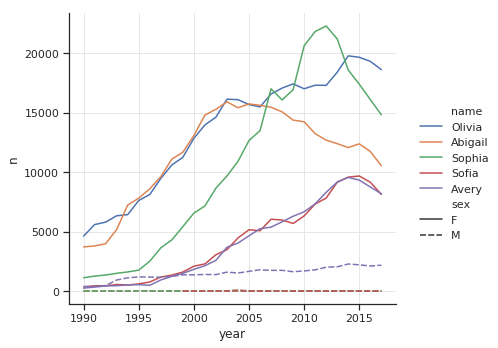

In [9]:
a = df[df.name.isin(['Abigail', 'Sophia', 'Sofia', 'Olivia', 'Avery'])]
a_plt = sns.relplot(x='year', y='n', hue='name', style='sex', kind='line', ci=None, data=a)
a_plt.fig.set_size_inches(7.5, 5)

Suppose your selected name is Sophia and soundalikes

<a id='prophet'></a>

## Prophet for prediction of naming trends

Prophet is an R/Python library available from: https://facebook.github.io/prophet/

As Prophet seems to be focused on more frequent data, I'm not convinced it works well with low resolution/infrequent data such as this yearly name data. Of course, I may just not understand how to properly specify parameters to get it to work right. *Update:* After having gone through an exercise (below) of similar analysis using ARIMA, I believe the problem is due to the nature of the data and the complexities with baby naming rather than with Prophet/ARIMA.

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [10]:
# select counts without respect to gender
a = orig_df[(orig_df.name.isin(['Sophia', 'Sofia']))].copy()
#a = df[df.name.isin(['Sophia', 'Sofia'])]
pdf = a.groupby(['year'])['n'].sum().reset_index()
pdf.rename(columns={"year": "ds", "n": "y"}, inplace=True)
pdf['ds'] = pd.to_datetime(pdf['ds'], format='%Y')

Prophet with just most basic parameters detects vary basic linear trend lines. Prediction is not very detailed and likely worse than what a human would deduce when looking at a graph of the data.

/Users/seth/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/Users/seth/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


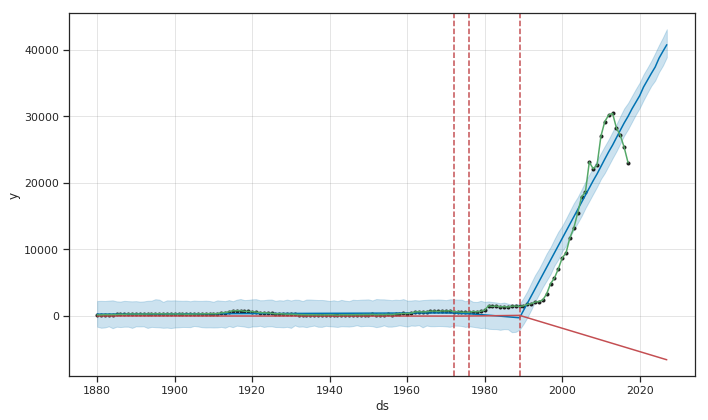

In [11]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative')
m.fit(pdf)
# predict 10 years out
future = m.make_future_dataframe(periods=10, freq='Y')
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# show actual data in green
plt.plot(pdf.ds, pdf.y, 'g')

**Note:** In this case, we have no within year seasonality for naming (which might actually exist, but we only have year-end totals), but Prophet fits a function depicting within year seasonality anyway

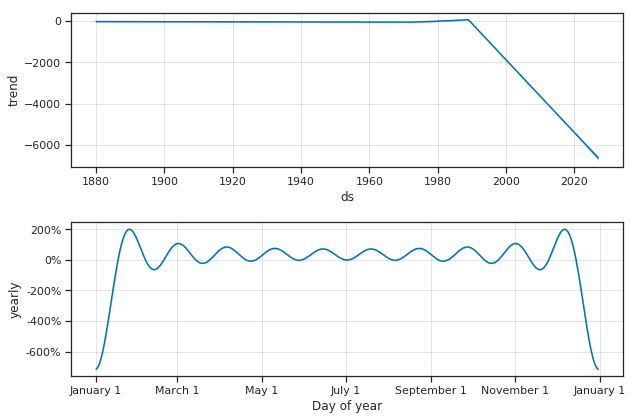

In [12]:
fig = m.plot_components(forecast)

Prophet with additional parameters follows the actuals much closer. Prediction still is not very detailed and likely worse than what a human would deduce when looking at a graph of the data and comparing to other naming trends.

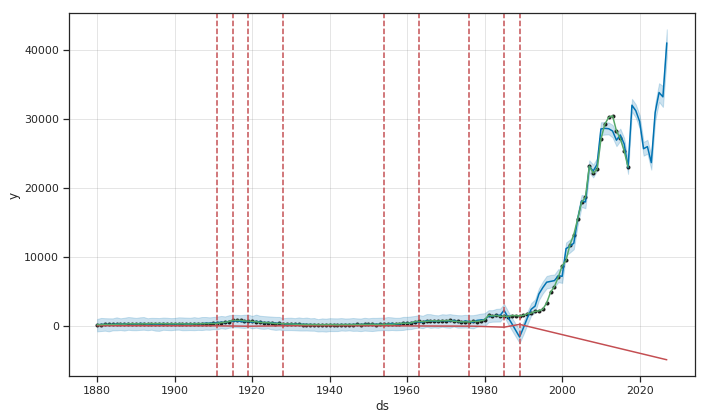

In [13]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative', changepoint_prior_scale = 0.5)#, yearly_seasonality = 1000)
m.add_seasonality(name='cust2', period=2, fourier_order=5)
m.add_seasonality(name='cust3', period=3, fourier_order=5)
m.add_seasonality(name='cust4', period=4, fourier_order=5)
m.add_seasonality(name='cust5', period=5, fourier_order=5)
m.fit(pdf)
# predict 10 years out
future = m.make_future_dataframe(periods=10, freq='Y')
forecast = m.predict(future)
fig = m.plot(forecast, plot_cap=False)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# show actual data in green
plt.plot(pdf.ds, pdf.y, 'g')

<a id='arima'></a>

## ARIMA for prediction of naming trends

Although this ARIMA section is more detailed than the Prophet section, my sense is that due to outside influences for naming trends (popular media, name saturation, cultural/social trends) it is not possible to accurately predict naming trends from historical naming counts alone.

Resources I found useful when applying ARIMA:
 * https://www.kaggle.com/magiclantern/co2-emission-forecast-with-python-arima-v2/notebook
 * https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
 * https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima

In [14]:
# to do - add this section
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pylab import rcParams
from pandas.plotting import autocorrelation_plot

In [15]:
rcParams['figure.figsize'] = 15, 12

In [16]:
a = orig_df[(orig_df.name.isin(['Sophia', 'Sofia']))].copy()
ts = a.groupby(['year'])['n'].sum()
# if a.year[0] is a string it treats it as a year; if it is an integer, it treats it as nanoseconds
# see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets for options
ts.index = pd.date_range(str(a.year[0]), periods=len(ts), freq='Y')
ts.head()

1880-12-31    138
1881-12-31    128
1882-12-31    179
1883-12-31    159
1884-12-31    170
Freq: A-DEC, Name: n, dtype: int32

In [17]:
# don't have monthly data, so this doesn't work
#decomposition = seasonal_decompose(ts)

In [18]:
def TestStationaryPlot(ts, plot_label = None):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    if plot_label is not None:
        plt.title('Rolling Mean & Standard Deviation (' + plot_label + ')', fontsize = 25)
    else:
        plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)
    
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

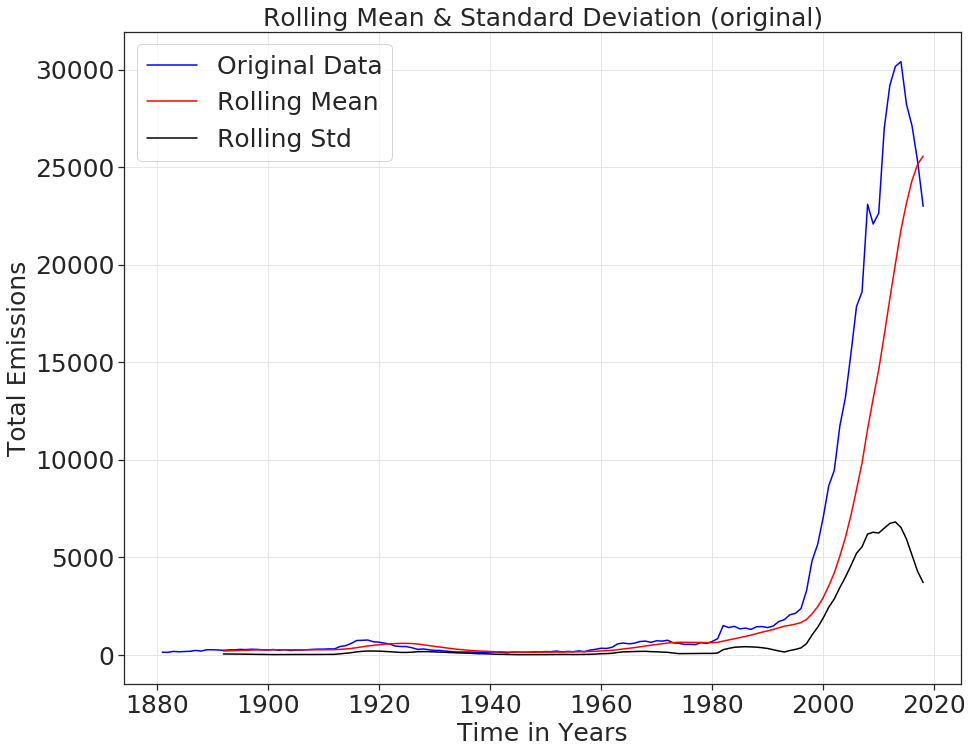

In [19]:
TestStationaryPlot(ts, 'original')

In [20]:
# while most of the data is farily flat for the time period shown (1880 - 1980)
#visual inspection of data doesn't seem to be stationary
TestStationaryAdfuller(ts)

Test Statistic                  -3.684853
p-value                          0.004331
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [21]:
# this is what is looked at for stationarity (is that a word?)
#12*(nobs/100)^{1/4}
nobs = len(ts)
12*(nobs/100)**(1/4)

13.006217658965213

In [22]:
moving_avg = ts.rolling(5).mean()
moving_avg_diff = ts - moving_avg
moving_avg_diff.head(13)

1880-12-31     NaN
1881-12-31     NaN
1882-12-31     NaN
1883-12-31     NaN
1884-12-31    15.2
1885-12-31    20.8
1886-12-31    43.8
1887-12-31     9.2
1888-12-31    54.4
1889-12-31    35.8
1890-12-31    12.2
1891-12-31    -8.0
1892-12-31     2.2
Freq: A-DEC, Name: n, dtype: float64

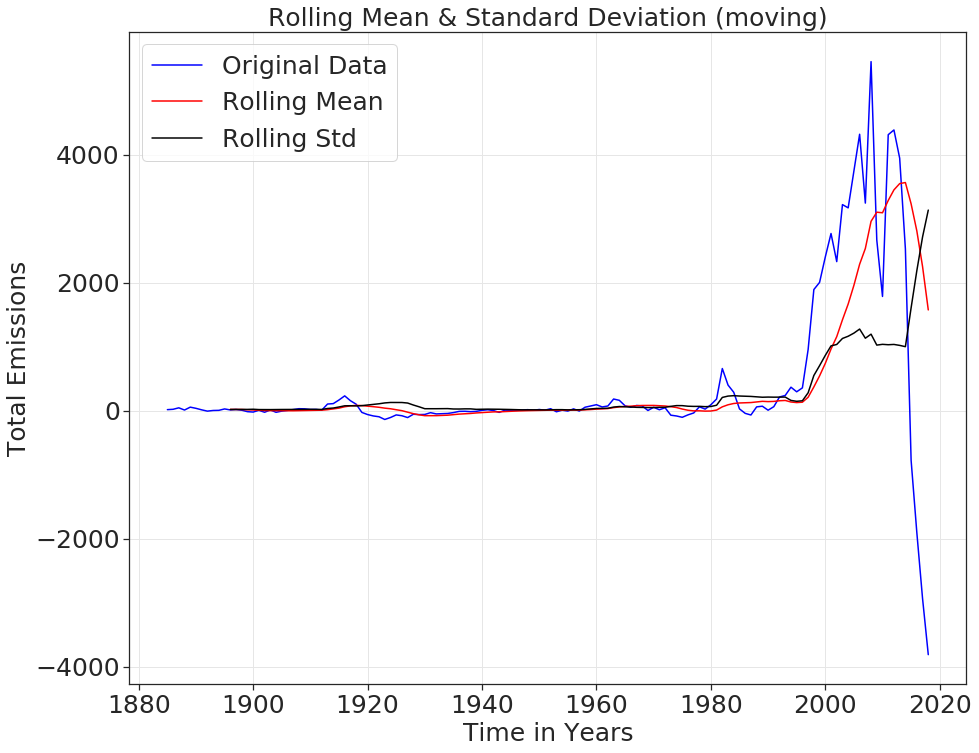

Test Statistic                  -3.833713
p-value                          0.002581
#Lags Used                      12.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [23]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff, 'moving')
TestStationaryAdfuller(moving_avg_diff)

### Autocorrelation Plots

When looking at all data available (1880 to present) it appears that the current value seems to be highly correlated with the previous 14 or so values; closer to the present value is more correlated. Tested a few different names and correlation lag may be as high as 20.

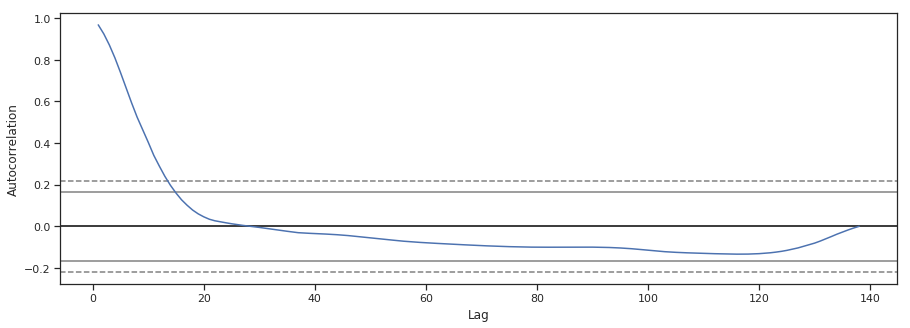

In [24]:
fig, ax = plt.subplots(figsize = (15, 5))
ax = autocorrelation_plot(ts, ax=ax)
#plt.vlines(range(0, 121, 2), -1, 1, linestyle="dashed")

These are autocorrelation plots from Statsmodel

/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


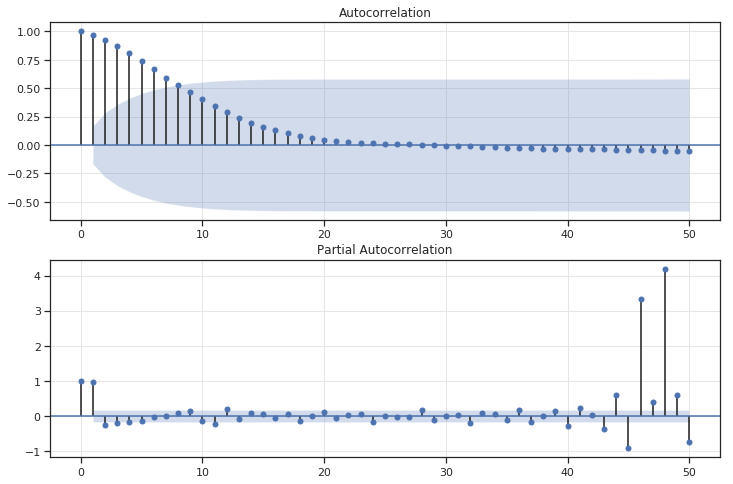

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=50, ax=ax2)

In [26]:
p = range(0, 20) #max based on plots above (though not specifically for the currently selected name)
d = range(0, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets

# for ARIMA model building, only use first 90%, save last 10% for testing/validation
n = .9
train = ts.head(int(len(ts) * .9))

As an exercise, I thought I'd try a more exhaustive grid search. This is very CPU intensive - run time on a 2017 Macbook Pro 15" was a little over 16 hours

End result is quite a it better than the grid search results from the smaller/quicker set of pdq values.

With these pqd parameters

```python
p = range(0, 21)
d = range(0, 21)
q = range(0, 21)
```

and running the parallel grid search, this is the best model found:

    Best AIC found: 1285.1007195040975 with parameters (17, 7, 20)
                               Statespace Model Results                           
    ==============================================================================
    Dep. Variable:                      n   No. Observations:                  124
    Model:             SARIMAX(17, 7, 20)   Log Likelihood                -635.197
    Date:                Sat, 18 May 2019   AIC                           1346.395
    Time:                        09:52:12   BIC                           1443.840
    Sample:                    12-31-1880   HQIC                          1385.784
                             - 12-31-2003                                         
    Covariance Type:                  opg                                         
    ==============================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
    ------------------------------------------------------------------------------
    ar.L1         -4.1069      0.922     -4.452      0.000      -5.915      -2.299
    ar.L2         -9.6938      3.413     -2.840      0.005     -16.384      -3.004
    ar.L3        -17.4916      7.477     -2.339      0.019     -32.146      -2.837
    ar.L4        -26.9092     12.611     -2.134      0.033     -51.626      -2.192
    ar.L5        -36.6562     18.178     -2.017      0.044     -72.284      -1.028
    ar.L6        -45.2342     23.416     -1.932      0.053     -91.129       0.661
    ar.L7        -51.5134     27.658     -1.862      0.063    -105.723       2.696
    ar.L8        -55.1616     30.470     -1.810      0.070    -114.881       4.558
    ar.L9        -56.1372     31.828     -1.764      0.078    -118.519       6.245
    ar.L10       -54.0797     31.769     -1.702      0.089    -116.346       8.187
    ar.L11       -48.7628     29.972     -1.627      0.104    -107.506       9.981
    ar.L12       -40.3622     26.283     -1.536      0.125     -91.876      11.151
    ar.L13       -29.7790     20.715     -1.438      0.151     -70.380      10.822
    ar.L14       -19.0493     14.046     -1.356      0.175     -46.579       8.480
    ar.L15       -10.3618      7.890     -1.313      0.189     -25.825       5.102
    ar.L16        -4.2783      3.633     -1.177      0.239     -11.400       2.843
    ar.L17        -0.8834      1.104     -0.800      0.424      -3.047       1.280
    ma.L1         -1.3483      1.294     -1.042      0.298      -3.885       1.189
    ma.L2         -0.2032      1.761     -0.115      0.908      -3.655       3.249
    ma.L3         -0.1253      1.199     -0.104      0.917      -2.476       2.225
    ma.L4         -0.3631      1.127     -0.322      0.747      -2.572       1.845
    ma.L5         -0.6447      1.138     -0.566      0.571      -2.875       1.586
    ma.L6          0.7688      1.052      0.731      0.465      -1.293       2.830
    ma.L7         -0.7535      1.707     -0.441      0.659      -4.099       2.592
    ma.L8          0.2781      1.159      0.240      0.810      -1.994       2.550
    ma.L9         -0.8792      1.291     -0.681      0.496      -3.410       1.651
    ma.L10        -0.0283      1.521     -0.019      0.985      -3.010       2.954
    ma.L11        -0.6554      1.365     -0.480      0.631      -3.332       2.021
    ma.L12         0.2506      0.834      0.300      0.764      -1.385       1.886
    ma.L13         0.1984      1.273      0.156      0.876      -2.297       2.694
    ma.L14        -0.0043      1.038     -0.004      0.997      -2.040       2.031
    ma.L15        -0.7166      1.151     -0.623      0.533      -2.972       1.539
    ma.L16        -0.2745      1.030     -0.267      0.790      -2.293       1.744
    ma.L17        -0.2298      1.171     -0.196      0.844      -2.526       2.066
    ma.L18         0.3842      1.140      0.337      0.736      -1.850       2.619
    ma.L19        -0.6473      1.009     -0.641      0.521      -2.625       1.330
    ma.L20         0.3517      0.950      0.370      0.711      -1.509       2.213
    sigma2      9586.4777      0.004   2.45e+06      0.000    9586.470    9586.485
    ===================================================================================
    Ljung-Box (Q):                       24.13   Jarque-Bera (JB):                 0.30
    Prob(Q):                              0.98   Prob(JB):                         0.86
    Heteroskedasticity (H):               2.55   Skew:                            -0.02
    Prob(H) (two-sided):                  0.01   Kurtosis:                         3.27
    ===================================================================================

    Warnings:
    [1] Covariance matrix calculated using the outer product of gradients (complex-step).
    [2] Covariance matrix is singular or near-singular, with condition number 1.69e+24. Standard errors may be unstable.
    CPU times: user 21.8 s, sys: 4.06 s, total: 25.9 s
    Wall time: 16h 17min 58s

Grid search results were saved with this:

```python
filename = 'aic_results_gridsearch.pickle'

with open(filename, 'wb') as f:
    pickle.dump(aic_results, f)
```

Perform a grid search to find the best ARIMA model



Change this from markdown to code to run serial grid search

```python
%%time

import warnings
warnings.filterwarnings('ignore') # ignore warning messages in this cell

aic_results = pd.DataFrame(columns=['aic', 'param'])
for param in pdq:
    try:
        # found that SARIMAX works with a wider range of p,d,q values
        #mod = ARIMA(ts,
        #            order=param,
        #            freq='A-DEC') #see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets for options
        mod = SARIMAX(train,
                      order=param,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        # some methods fail to converge; increasing max iterations helps
        # some methods have verbose output
        #results = mod.fit(maxiter=200, method='nm')
        results = mod.fit()
        if np.isnan(results.aic):
            a = 1
            #print('No AIC generated for ARIMA:{}'.format(param))
        else:
            #print('ARIMA:{} - AIC:{}'.format(param, results.aic))
            aic_results = aic_results.append({
                'aic': results.aic,
                'param': param},
                ignore_index=True)
    except Exception as e:
        # lots of ARIMA values end in an exception - guess I need to understand this better
        print('exception', e)
        continue
    if len(aic_results) % 20 == 0:
        print('Checked', len(aic_results), 'parameters so far.')

aic_results = aic_results.sort_values('aic').reset_index(drop=True)
print('Best AIC found:', aic_results.head(1).aic.values[0], 'with parameters', aic_results.head(1).param.values[0])

model = SARIMAX(ts, order=aic_results.head(1).param.values[0], enforce_stationarity=False)
model_fit = model.fit()
print(model_fit.summary())

warnings.filterwarnings('default')
```

Parallel version of grid search for faster processing

In [27]:
def calc_arima(df_in):
    aic_results = pd.DataFrame(columns=['aic', 'param'])
    print('Checking', len(df_in), 'parameters')
    for param in df_in.param.values:
        try:
            # found that SARIMAX works with a wider range of p,d,q values
            #mod = ARIMA(train,
            #            order=param,
            #            freq='A-DEC') #see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets for options
            mod = SARIMAX(train,
                          order=param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            # some methods fail to converge with default iterations of 50; increasing max iterations helps
            # some methods have verbose output
            #results = mod.fit(maxiter=200, method='nm')
            results = mod.fit(maxiter=150)
            if np.isnan(results.aic):
                a = 1
                #print('No AIC generated for ARIMA:{}'.format(param))
            else:
                #print('ARIMA:{} - AIC:{}'.format(param, results.aic))
                aic_results = aic_results.append({
                    'aic': results.aic,
                    'param': param},
                    ignore_index=True)
        except Exception as e:
            # lots of ARIMA values end in an exception - guess I need to understand this better
            print('exception', e)
            continue
    return aic_results

In [28]:
%%time

import warnings
warnings.filterwarnings('ignore') # ignore warning messages in this cell

pdq_input_df = pd.DataFrame(columns=['aic', 'param'])
pdq_input_df['param'] = pdq

num_processes = psutil.cpu_count(logical=False)
num_partitions = num_processes * 2 #smaller batches to get more frequent status updates
with Pool(processes=num_processes) as pool:
    df_split = np.array_split(pdq_input_df, num_partitions)
    df_out = pd.concat(pool.map(calc_arima, df_split),ignore_index=True)
    
aic_results = df_out.sort_values('aic').reset_index(drop=True)
print('Best AIC found:', aic_results.head(1).aic.values[0], 'with parameters', aic_results.head(1).param.values[0])

model = SARIMAX(train, order=aic_results.head(1).param.values[0], enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())

warnings.filterwarnings('default')

Checking 23 parameters
Checking 23 parameters
Checking 23 parameters
Checking 23 parameters
Checking 22 parameters
Checking 22 parameters
Checking 22 parameters
Checking 22 parameters
Best AIC found: 1320.0134820280853 with parameters (19, 2, 0)
                           Statespace Model Results                           
Dep. Variable:                      n   No. Observations:                  124
Model:              SARIMAX(19, 2, 0)   Log Likelihood                -640.007
Date:                Mon, 20 May 2019   AIC                           1320.013
Time:                        13:53:07   BIC                           1372.708
Sample:                    12-31-1880   HQIC                          1341.357
                         - 12-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

In [29]:
aic_results.shape

(180, 2)

### Visualize the grid search results

Make sure you have Matplotlib and Jupyter setup correctly for interactive visualizations - it makes it much easier to use. See instructions at:

https://github.com/matplotlib/jupyter-matplotlib

In [30]:
filename = 'aic_results_gridsearch.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as f:
        grid_results = pickle.load(f)
        
grid_results.head()

,aic,param
0,1285.100720,"(17, 7, 20)"
1,1288.867756,"(16, 6, 20)"
2,1289.267885,"(18, 7, 20)"
3,1291.031231,"(17, 6, 20)"
4,1291.208972,"(20, 4, 1)"


In [31]:
# as some AIC values are very large, it is hard to see where good values are visually;
# picked this value as it seemed to show some useful information
grid_results['clipped_aic'] = grid_results.aic.clip(upper=5000)

In [32]:
# to do an interactive matplotlib chart, uncomment the proper line below
# for jupyter notebook
#%matplotlib notebook
# for jupyter lab
#%matplotlib widget

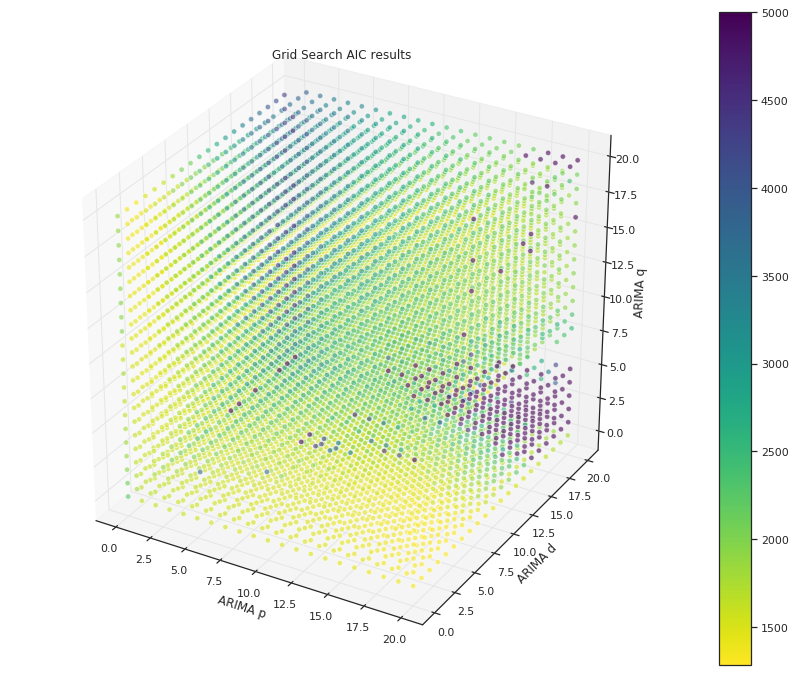

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cmap = matplotlib.cm.get_cmap('viridis_r')
normalize = matplotlib.colors.Normalize(vmin=min(grid_results['clipped_aic']), vmax=max(grid_results['clipped_aic']))
colors = [cmap(normalize(value)) for value in grid_results['clipped_aic']]

ax.scatter(grid_results['param'].apply(lambda v: (v[0])),
           grid_results['param'].apply(lambda v: (v[1])),
           grid_results['param'].apply(lambda v: (v[2])),
           s=30,
           alpha=0.6,
           edgecolors='w',
           c=colors
          )

ax.set_xlabel('ARIMA p')
ax.set_ylabel('ARIMA d')
ax.set_zlabel('ARIMA q')

plt.title('Grid Search AIC results')

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.show()

Through interactive manipulation of the 3-dimensional space, it appears that:

* higher p values (> 10), smaller d values (< 8), and almost any q value gives a low AIC.
* higher p values (> 10), larger d values (> 10), and lower q values (< 5) give a high AIC.

### Now continue on with ARIMA

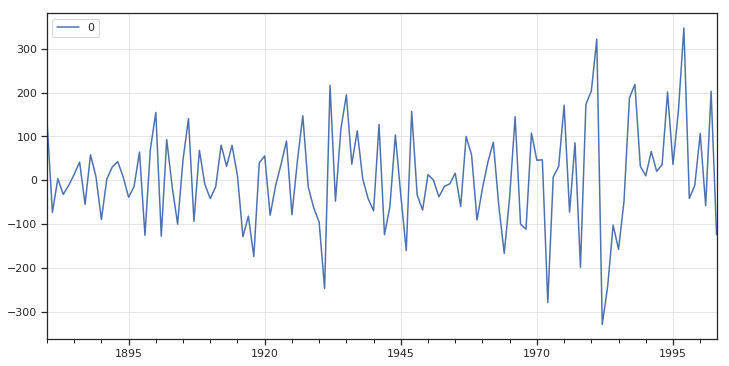

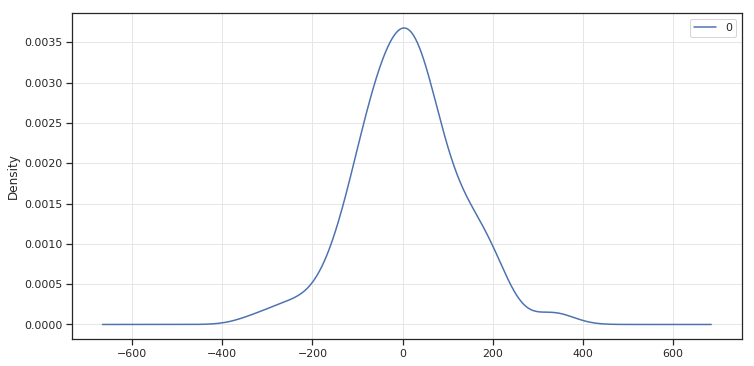

                0
count  124.000000
mean     9.275733
std    113.671632
min   -328.179431
25%    -59.295530
50%      7.809856
75%     73.175630
max    347.030830


In [34]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,6))
plt.show()
residuals.plot(kind='kde', figsize=(12, 6))
plt.show()
print(residuals.describe())

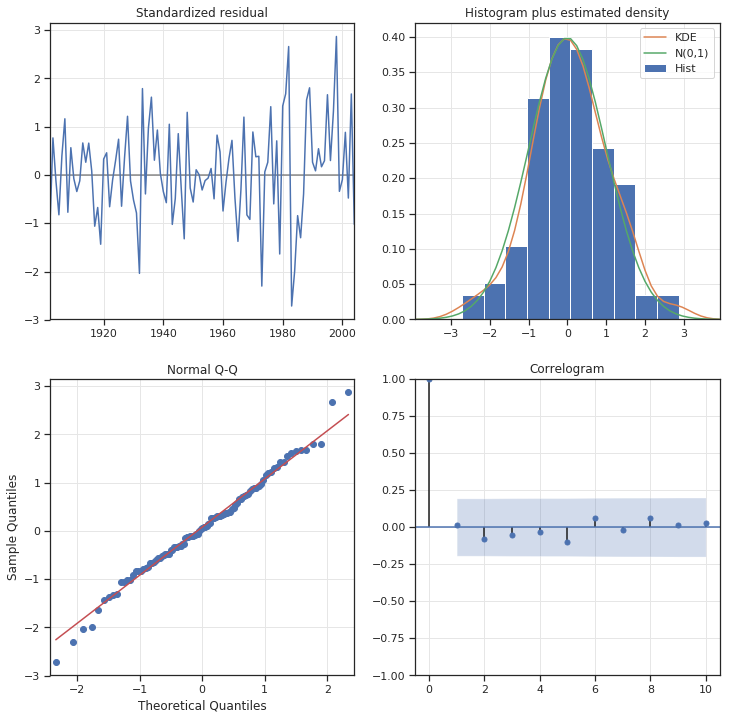

In [35]:
model_fit.plot_diagnostics(figsize=(12, 12))
plt.show()

Now generate prediction for all data + future

In [36]:
ts.index[-1] + pd.DateOffset(years=10)

Timestamp('2027-12-31 00:00:00')

In [37]:
end_period = ts.index[-1] + pd.DateOffset(years=10)
pred = model_fit.get_prediction(start=ts.index[0], end=end_period, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


,lower n,upper n
1880-12-31,-3394.757202,3394.757202
1881-12-31,-2219.660029,2621.897903
1882-12-31,-2056.831002,2406.986537
1883-12-31,-1799.471917,2181.217839
1884-12-31,-1804.706395,2167.357922


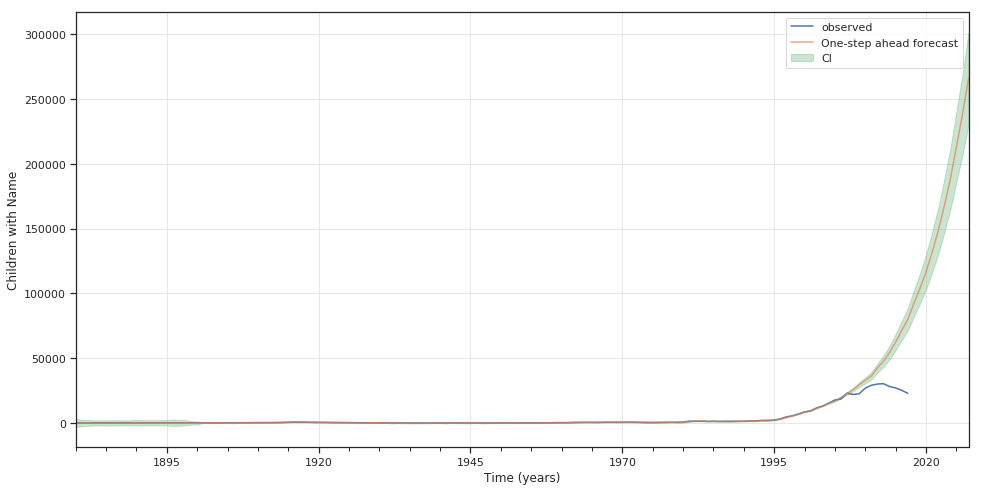

In [38]:
ax = ts.plot(label='observed', figsize=(16, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.3, label='CI')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Children with Name')
plt.legend()

plt.show()

In [39]:
# if want to just check last 10 years of acutals, use this
#forecast = pred.predicted_mean[ts.index[-10]:ts.index[-1]]
#truth = ts[-10:]
# if wnat to check all actuals vs predictions, use this
forecast = pred.predicted_mean[:ts.index[-1]]
truth = ts

# Compute the mean square error
mse = ((forecast - truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((forecast-truth)**2)/len(forecast))))

The Mean Squared Error (MSE) of the forecast is 57275964.65
The Root Mean Square Error (RMSE) of the forcast: 7568.0886


Now try generating a dynamic forecast for last 10 years of actual data

In [40]:
pred_dynamic = model_fit.get_prediction(start=ts.index[-10], end=ts.index[-1], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


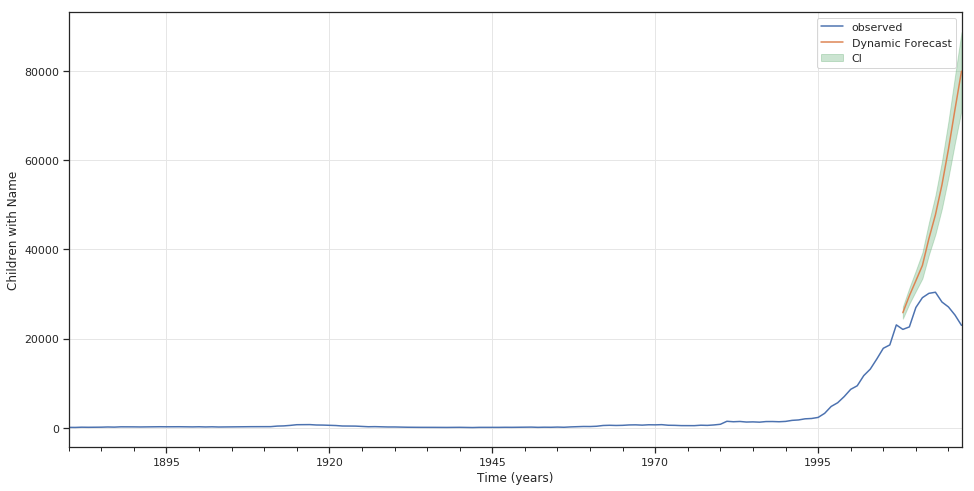

In [41]:
ax = ts.plot(label='observed', figsize=(16, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='g', 
                alpha=.3,
                label='CI')

# # ax.fill_betweenx(ax.get_ylim(), 
# #                  ts.index[-10], 
# #                  ts.index[-1],
# #                  alpha=.1, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Children with Name')

plt.legend()
plt.show()

In [42]:
# Extract the predicted and true values of our time series (just last 10 years for this dynamic forecast)
forecast = pred_dynamic.predicted_mean
original = ts[-10:]

# Compute the mean square error
mse = ((forecast - original) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((forecast-original)**2)/len(forecast))))

The Mean Squared Error (MSE) of the forecast is 790023736.16
The Root Mean Square Error (RMSE) of the forcast: 28107.3609


<a id='sound_analysis'></a>

### Combine names based on how they sound

As each entry in the babynames dataset is based on spelling, evaluate different sound based algorithms to see how to combine/reduce number of names.

See the [soundconflation](soundconflation.ipynb) notebook for analysis of various phonetic algorithms.

End result is that the Abydos python library has lots of options and I like the Beider & Morse algorithm the best for the purposes of this analysis.

For combination of names based on Beider Morse algorithm, will just look at most recent year.

#### Export names file for testing/evaluation of phonetic algorithms

In [43]:
names = pd.DataFrame()
#apdf = df[['year', 'sex', 'name', 'n', 'prop']][df.year == 1990].head(100).copy()
names['name'] = df.name.unique()
print(names.shape)

with open('ssn_names_only.pickle', 'wb') as f:
    pickle.dump(names, f)

(77092, 1)


Build the data frame of names and beidermorse values

In [44]:
from abydos import phonetic as ap

def process_df(function, label, df_in):
    # this is is beidermorse specific; remove this function partial and you can actually parallelize
    # any method that doesn't require additional parameters
    func = partial(function, language_arg = 'english')
    df_in[label] = df_in.name.map(func)
    return df_in

def parallelize(inputdf, function, label):
    num_processes = psutil.cpu_count(logical=False)
    num_partitions = num_processes * 2 #smaller batches to get more frequent status updates (if function provides them)
    func = partial(process_df, function, label)
    with Pool(processes=num_processes) as pool:
        df_split = np.array_split(inputdf, num_partitions)
        df_out = pd.concat(pool.map(func, df_split))
    return df_out

filename = 'names_beidermorse.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as f:
        names = pickle.load(f)
else:
    names = parallelize(names, ap.BeiderMorse().encode, 'beidermorse')
    # convert string of names space separated to a set for much faster lookup
    names['bmset'] = names['beidermorse'].str.split().apply(set)

    with open(filename, 'wb') as f:
        pickle.dump(names, f)

names.head()

,name,beidermorse,bmset
0,Jessica,zYsQki zYsiki zYsDki zisQki zisiki zisDki zYsi...,"{zisQki, zisiki, zisiko, zYsQko, zYsika, zisQk..."
1,Ashley,izlii izlD izla izli ozlii ozlD ozla ozli azli...,"{izli, azlii, izlii, ozla, azla, ozlii, ozli, ..."
2,Brittany,brQtini britini brDtini britoni brQtoni britan...,"{britani, brQtoni, britini, brQtini, brDtini, ..."
3,Amanda,imindi imndi imindo imndo iminda imnda imondi ...,"{omindi, iminda, imondo, amandi, imanda, omond..."
4,Samantha,siminti simnti siminto simnto siminta simnta s...,"{samnta, simonti, somanti, samnto, samanto, sa..."


In [45]:
checklist = names[names.name == 'Sofia'].beidermorse.values[0].split()
def check_fn(input):
    return any(x in input.split() for x in checklist)

names[names.beidermorse.map(check_fn)].head()

,name,beidermorse,bmset
250,Sophia,sofii sofio sofia safii safio safia,"{sofii, sofia, sofio, safii, safio, safia}"
646,Sofia,sofii sofio sofia safii safio safia,"{sofii, sofia, sofio, safii, safio, safia}"
9955,Safia,sifii sifio sifia sofii sofio sofia safii safi...,"{sifii, sifia, sofii, sofia, sifio, sofio, saf..."
12562,Safaa,sifii sifio sifD sifia sifoi sifoo sifoa sifai...,"{sifia, sifai, sifoi, sifo, safo, sifao, sofao..."
29240,Safiah,sifii sifio sifia sofii sofio sofia safii safi...,"{sifii, sifia, sofii, sofia, sifio, sofio, saf..."


Create key-value version of Beider Morse mapping - found this improves performance

In [46]:
def f(name, bmset):
    return pd.DataFrame(zip([name] * len(bmset), list(bmset)), columns=('name', 'beidermorse'))
kv_names = pd.concat([f(n,b) for n, b in zip(names['name'], names['bmset'])])

In [47]:
def calc_sound_totals(df_in):
    df_out = df_in.copy()
    df_out['counted'] = False
    df_out['alt_n'] = 0
    df_out['alt_prop'] = 0.0
    df_out['mapped_to'] = ''
    
    filt_names = kv_names.merge(df_out, on='name')[['name', 'beidermorse']]

    # process each row of dataframe
    def create_df_out_n(row):
        # should do no further processing if this row has already been counted
        if (df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'counted'].all() == True):
            return

        # find matching names        
        checklist = filt_names[filt_names.name == row['name']].beidermorse.values
        found = filt_names[filt_names.beidermorse.isin(checklist)]['name'].unique()
        
        # aggregate count, excluding counted names, for all found names into df_out_name
        df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'alt_n'] = df_out[(df_out.name.isin(found)) & 
                               (df_out.year == row.year) &
                               (df_out.sex == row.sex) &
                               (df_out.counted == False)]['n'].sum()
        
        # set counted flag for found names in group
        # ? how to update just group ?
        df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex), 'counted'] = True
        df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex), 'mapped_to'] = row['name']

    start = timer()
    gdf = df_out.groupby(['year', 'sex'])
    for name, group in gdf:
        print('processing name:', name)
        g = group.sort_values('n', ascending=False).copy()
        g.apply(create_df_out_n, axis=1)

    end = timer()
    print('create out_n', end - start, 'seconds')
    
    # create df_out_prop
    def create_df_out_prop(row):
        df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'alt_prop'] = row['alt_n'] / gsum

    start = timer()
    for name, group in gdf:
        gsum = group['alt_n'].sum()
        group.apply(create_df_out_prop, axis=1)
    end = timer()
    print('create out_prop', end - start, 'seconds')

    return df_out

This process takes about 20 minutes... While this is the improved version, need to improve much more; seems parallelization is the next step

In [48]:
alt = df[df.year == 2017].copy()
alt['counted'] = False
alt['alt_n'] = 0
alt['alt_prop'] = 0.0
alt.head()

filename = 'calc_sound_totals.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as f:
        out = pickle.load(f)
else:
    out = calc_sound_totals(alt)

    with open(filename, 'wb') as f:
        pickle.dump(out, f)

In [49]:
out.sort_values(['year', 'sex', 'name']).head()

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1906221,2017.0,F,Aabriella,6,0.000003,True,0,0.000000,Aubrielle
1897210,2017.0,F,Aadhira,26,0.000014,True,0,0.000000,Yadira
1893108,2017.0,F,Aadhya,290,0.000155,True,590,0.000345,Aadhya
1907990,2017.0,F,Aadilynn,5,0.000003,True,0,0.000000,Adelyn
1906222,2017.0,F,Aaditri,6,0.000003,True,0,0.000000,Aditri


In [50]:
out[out.name.isin(['Abigail', 'Sophia', 'Sofia', 'Olivia', 'Avery'])].head()

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1892198,2017.0,F,Olivia,18632,0.009938,True,20437,0.011939,Olivia
1892201,2017.0,F,Sophia,14831,0.007910,True,23117,0.013504,Sophia
1892206,2017.0,F,Abigail,10551,0.005627,True,11274,0.006586,Abigail
1892210,2017.0,F,Avery,8186,0.004366,True,9417,0.005501,Avery
1892211,2017.0,F,Sofia,8134,0.004338,True,0,0.000000,Sophia


In [51]:
len(out.mapped_to.unique())

10681

<a id='popularity'></a>

### Name popularity

Primary/Secondary school is the location most children will interact with a large number of their birth cohort. While many schools use on or around September 1 for the kindergarten cutoff age, it can actually vary quite a bit - see http://ecs.force.com/mbdata/MBQuest2RTanw?rep=KK3Q1802

In highschool, college, and adulthood interactions are with a broader range of ages than in early school years, so a larger time period might be more appropriate for that type of analysis.

To Do:
* Should consider regional distributions of names, but where to get that data?
* Should consider ethnic popularity by region, but where to get that data?

National school class size: 21

Source: https://nces.ed.gov/fastfacts/display.asp?id=28, though only has public schools from 2011-2012, so is outdated

National Average Public School size: 503

Source: https://www.publicschoolreview.com/average-school-size-stats/national-data

Suppose we want to see how many other kids would have names like 'Sophia':

In [52]:
from scipy.stats import binom

# p = probability/proportion of name
# n = size of group to consider
def calc_dup_prob(p, n):
    k = 2
    ans = 0.0
    for x in range(k, n + 1):
        ans += binom.pmf(x, n, p)
        # alternatively see https://en.wikipedia.org/wiki/Binomial_distribution#Cumulative_distribution_function
        # comb(n, x) * p**x * (1 - p)**(n-x))
    return ans

school_size = 503
class_size = 21

print("Probability of child with same name in a given class: ", calc_dup_prob(out[out.name == 'Sophia'].alt_prop.sum(), class_size))
print("Probability of child with same name in a given school: ", calc_dup_prob(out[out.name == 'Sophia'].alt_prop.sum(), school_size))

Probability of child with same name in a given class:  0.03236602020314888
Probability of child with same name in a given school:  0.9916020167695265


<a id='gender'></a>

### Check if name is mostly one gender or is there some amount of overlap

Gender overlap levels were selected to approximately balance the high and medium overlap groups

In [53]:
out[(out.name == 'Sophia') & (out.mapped_to == 'Sophia')]

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1892201,2017.0,F,Sophia,14831,0.007910,True,23117,0.013504,Sophia
1915957,2017.0,M,Sophia,17,0.000009,True,24,0.000013,Sophia


In [54]:
mnames = out[(out.alt_n > 0) & (out.sex == 'M')]
fnames = out[(out.alt_n > 0) & (out.sex == 'F')]
both = out[out.name.isin(set(mnames.mapped_to.unique()) & set(fnames.mapped_to.unique()))].copy()
print('Number of names that are both gender:', len(both)//2)

Number of names that are both gender: 837


In [55]:
both.head()

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1892198,2017.0,F,Olivia,18632,0.009938,True,20437,0.011939,Olivia
1892200,2017.0,F,Isabella,15100,0.008054,True,18816,0.010992,Isabella
1892201,2017.0,F,Sophia,14831,0.007910,True,23117,0.013504,Sophia
1892202,2017.0,F,Mia,13437,0.007167,True,17484,0.010214,Mia
1892203,2017.0,F,Charlotte,12893,0.006877,True,12893,0.007532,Charlotte


In [56]:
# # to evaluate all names and report values
# for name in both.name.unique():
#     fcount = both[(both.name == name) & (both.sex == 'F')].alt_n.values[0]
#     mcount = both[(both.name == name) & (both.sex == 'M')].alt_n.values[0]
#     if ((fcount <= (mcount + mcount * .20)) & (fcount >= (mcount - mcount * .20))):
#         print('name: ', name, 'has high gender overlap')
#     elif ((fcount <= (mcount + mcount * .40)) & (fcount >= (mcount - mcount * .40))):
#         print('name: ', name, 'has medium gender overlap')
#     else:
#         print('name: ', name, 'has low gender overlap')
        
def gender_eval(name):
    fcount = both[(both.name == name) & (both.sex == 'F')].alt_n.values[0]
    mcount = both[(both.name == name) & (both.sex == 'M')].alt_n.values[0]
    if ((fcount <= (mcount + mcount * .40)) & (fcount >= (mcount - mcount * .40))):
        return 'high'
    elif ((fcount <= (mcount + mcount * .70)) & (fcount >= (mcount - mcount * .70))):
        return 'medium'
    else:
        return 'low'

both['gender_overlap'] = both.name.apply(gender_eval)
both.gender_overlap.value_counts()

low       1168
medium     254
high       252
Name: gender_overlap, dtype: int64

In [57]:
# look at most common highly overlapping names
samp = both[both.gender_overlap == 'high'].sort_values('alt_n', ascending=False).head(5).name
both[both.name.isin(samp)].sort_values(['name', 'sex'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to,gender_overlap
1892355,2017.0,F,Finley,1859,0.000992,True,2252,0.001316,Finley,high
1910784,2017.0,M,Finley,1284,0.000654,True,1830,0.000998,Finley,high
1892470,2017.0,F,River,1166,0.000622,True,1195,0.000698,River,high
1910706,2017.0,M,River,1948,0.000992,True,1989,0.001084,River,high
1892408,2017.0,F,Rowan,1440,0.000768,True,2742,0.001602,Rowan,high
1910645,2017.0,M,Rowan,2827,0.001440,True,4175,0.002276,Rowan,high


In [58]:
# random sample of medium overlapping names
samp = samp = both[both.gender_overlap == 'medium'].name.sample(n=3, random_state=2213)
both[both.name.isin(samp)].sort_values(['name', 'sex'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to,gender_overlap
1895330,2017.0,F,Crimson,51,0.000027,True,62,0.000036,Crimson,medium
1913684,2017.0,M,Crimson,36,0.000018,True,42,0.000023,Crimson,medium
1904487,2017.0,F,Marvelous,8,0.000004,True,8,0.000005,Marvelous,medium
1923965,2017.0,M,Marvelous,5,0.000003,True,5,0.000003,Marvelous,medium
1896639,2017.0,F,Truth,32,0.000017,True,32,0.000019,Truth,medium
1912728,2017.0,M,Truth,60,0.000031,True,60,0.000033,Truth,medium


In [59]:
# random sample of low overlapping names
samp = samp = both[both.gender_overlap == 'low'].name.sample(n=3, random_state=2213)
both[both.name.isin(samp)].sort_values(['name', 'sex'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to,gender_overlap
1894250,2017.0,F,Paxton,95,0.000051,True,95,0.000055,Paxton,low
1910711,2017.0,M,Paxton,1898,0.000967,True,1898,0.001035,Paxton,low
1892606,2017.0,F,Ryan,770,0.000411,True,1586,0.000927,Ryan,low
1910548,2017.0,M,Ryan,7652,0.003898,True,8848,0.004823,Ryan,low
1895048,2017.0,F,Snow,59,0.000031,True,59,0.000034,Snow,low
1922454,2017.0,M,Snow,6,0.000003,True,6,0.000003,Snow,low
